In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
from rd_solver import *
sns.set(style='white')

## Model description
Here is the extracelluar proofreading model through protein gradient. Inspired by [Rob Phillips (2020)](https://doi.org/10.7554/eLife.60415), we conceive that kinetic proofreading can also be achieved in extracelluar model and realize specific ligand transportation.  
To achieve this, the model we consider will be divided into modules:  
1, Gradient formation module: This module is responsible for the formation of substrate gradient.Here we use the classic source-sink model. [Stapornwongkul(2020)](https:/10.1126/science.abb8205) showed that if we can use simple ligand-receptor system can build synthetic gradient in tissue and here we use similar method to build substrate gradient.
2, Proofreading module: This module includes a carrier that can bind to substrate and prevent it from assosication with receptor. And because of the decreasing substrate gradient and the different unbinding rate of substrates and carrier, the ratio of different complexes will change as they diffuse. Under the right conditions, the concentration of substrate complexes with larger koff [EW] should be << the concentration of substrate complexes with smaller koff[ER],and the complex can form a complete protease to cleave the membrane bound GFP/mcherry:
$$
A+R \rightleftharpoons AR \rightharpoonup R +  A_{cut}\\
B+R \rightleftharpoons BR \rightharpoonup R +  B_{cut}\\
A+A' \rightleftharpoons AA'\\
B+A' \rightleftharpoons BA'\\
$$
The reaction-diffusion functions are as follows:
$$
\frac{\partial A}{\partial t} = D_1 \frac{\partial^2 A}{\partial x^2} - k_{AA'}[A][A'] + r_{
    AA'}[AA'] + r_{AR}[AR] - k_{AR}[A][R]\\ 
\frac{\partial B}{\partial t} = D_2 \frac{\partial^2 B}{\partial x^2} - k_{BA'}[B][A'] + r_{BA'}[BA'] + r_{BR}[BR] - k_{BR}[B][R]\\
\frac{\partial A'}{\partial t} = D_3 \frac{\partial^2 A'}{\partial x^2}
                                 - k_{AA'}[A][A'] + r_{AA'}[AA']
                                 - k_{BA'}[B][A'] + r_{BA'}[BA']\\
\frac{\partial R}{\partial t} = D_4 \frac{\partial^2 A}{\partial x^2} - k_{AR}[A][R] + r_{AR}[AR]
                                 - k_{BR}[B][R] + r_{BR}[BR]
                                 + \gamma([AR]+[BR])\\
\frac{\partial AR}{\partial t} = D_5 \frac{\partial^2 AR}{\partial x^2} - k_{AR}[A][R] - r_{AR}[AR] - \gamma[AR]\\
\frac{\partial BR}{\partial t} = D_6 \frac{\partial^2 BR}{\partial x^2} - k_{AR}[B][R] - r_{BR}[BR] - \gamma[BR]\\
\frac{\partial AA'}{\partial t} = D_7 \frac{\partial^2 AA'}{\partial x^2} + k_{AA'}[A][A'] - r_{AA'}[AA'] \\
\frac{\partial BA'}{\partial t} = D_8 \frac{\partial^2 BA'}{\partial x^2} + k_{BA'}[B][A'] - r_{BA'}[BA'] \\

\frac{\partial A_{cut}}{\partial t} = D_9 \frac{\partial^2 A_{cut}}{\partial x^2} + \gamma[AR]\\
\frac{\partial B_{cut}}{\partial t} = D_{10} \frac{\partial^2 B_{cut}}{\partial x^2} + \gamma[BR]\\
$$

In [11]:
class RXN_params_yuanqi(object):
    """
    Container for reaction parameters
    """
    def __init__(self, **kwargs):
        """
        k_AC: association rate for A and Receptor
        r_AC: dissociation rate for AA'
        k_AR: association rate for A and Receptor
        r_AR: dissociation rate for A-Receptor complex
        k_BC: association rate for B and Receptor
        r_BC: dissociation rate for BA'
        k_BR: association rate for B and Receptor
        r_BR: dissociation rate for B-Receptor complex
        RTotal: Total receptor number
        gamma: receptor turnover rate ([X-R] --> R)
        deg: universal degradation rate for free proteins
        """
        # RTotal: Total receptor number (nM) 
        #self.RTotal = 2.7 # nM  0.0375 – 2.7 nM (corresponding to 18 –1300 molecules/µm2 and a 800 µm Matrigel layer on the cell surface)
        # k (nM-1*s-1) and r (s-1) of A+A' <-> AA' 
        self.k_AC = 1e-4   # /nM/s
        self.r_AC = 1e-4  # /s
        # k (nM-1*s-1) and r (s-1) of B+A' <-> BA'1

In [12]:
# Time points

t = np.arange(3600*1.0, 3600*48, 3600)

# number of grid points 
n_gridpoints = 451 # refer to the BMP model,because when their parameters are simulated, when L=3000, the value of citrine is close to 0
grid_spacing = 10 # µm refer to 293T cell length

# Physical length of system
L = grid_spacing * (n_gridpoints - 1) # µm

To explore all possible parameters for proofreading, we set a check point to judge if "proofreading" happen. Because as the diffusion happens, [AC]/[BC] can reach a very high value but with undetectable [BC] concentration.
So to ensure our proofreading ability is adapted to different conditions, we consider one effective proofreading event is that $\frac {ratio_{now}} {ratio_{eq}} > 100$ and $[BC]>10^{-3} nM$

### Yuanqi's parameters and conditions

In [13]:
def get_fidelity(sol,params=RXN_params_yuanqi()):
    sol = np.array(sol)
    sol = np.array(sol)
    AC = sol[4,-1]
    BC = sol[5,-1]
    fidelity = AC/BC
    return fidelity

In [14]:
def get_increased_fidelity(sol, params=RXN_params_yuanqi()):
    sol = np.array(sol)
    AC = sol[4,-1]
    BC = sol[5,-1]
    fidelity = AC/BC
    increased_fidelity = fidelity/params.ratio
    return increased_fidelity

In [15]:
def get_AC(sol, params=RXN_params_yuanqi()):
    sol = np.array(sol)
    AC = sol[4,-1]
    return AC 

In [16]:
def get_BC(sol, params=RXN_params_yuanqi()):
    sol = np.array(sol)
    BC = sol[5,-1]
    return BC 

In [17]:
def if_proofreading(sol, params, BC_limit=0):
   increased_fidelity = get_increased_fidelity(sol,params)
   sol = np.array(sol)
   AC = sol[4,-1]
   for idx, value in enumerate(AC):
      #if value < BC_limit:
      if increased_fidelity[idx] > 50:
         return [idx+1, value]
      #else:
         #return False
   return False

In [18]:
rxn_params = RXN_params_yuanqi()
diff_coeffs = DIFFUSION()
n_gridpoints = 451
sender_region = 200
grid_spacing = 10 # µm
L = grid_spacing * (n_gridpoints - 1) # µm

# Initialize
j_A = np.zeros(n_gridpoints)
j_A[0:sender_region] = 4e-4
j_B = np.zeros(n_gridpoints)
j_B[0:sender_region] = 4e-4
j_C = np.zeros(n_gridpoints)
j_C[0:sender_region] = 8e-4
j_R = np.zeros(n_gridpoints)
j_R[sender_region:] = 2e-4

j_a = np.zeros(n_gridpoints)
j_a[sender_region:] = 4e-4*0
j_b = np.zeros(n_gridpoints)
j_b[sender_region:] = 4e-4*0

j_ac = np.zeros(n_gridpoints)
j_ac[sender_region:] = 4e-4*0
j_bc = np.zeros(n_gridpoints)
j_bc[sender_region:] = 4e-4*0

production_rate = (j_A, j_B, j_C, j_a, j_b, j_ac, j_bc, j_R)

print(j_R)
rec_region = np.ones(n_gridpoints)
rec_region[:sender_region] = 0

# Initial concentration  
c_0_tuple = (np.zeros(n_gridpoints),np.zeros(n_gridpoints),
             np.zeros(n_gridpoints),np.zeros(n_gridpoints),
             np.zeros(n_gridpoints),np.zeros(n_gridpoints),
             np.zeros(n_gridpoints),np.zeros(n_gridpoints))
             

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.   

In [19]:
# Solve
diff_coeffs.D_A = 10
diff_coeffs.D_B = 10
diff_coeffs.D_C = 10
diff_coeffs.D_complex = 10

sol = RD_solve(c_0_tuple, t, L=L, derivs_0=0, derivs_L=0, 
            diff_coeff_fun=Diff_fun, diff_coeff_params=(diff_coeffs,), rxn_fun=RD_rxn, 
            rxn_params=(rxn_params, production_rate), rtol=1.49012e-8, atol=1.49012e-8)

#increased_fidelity_standard = get_increased_fidelity(sol,params=rxn_params)
#fidelity = get_fidelity(sol,params=rxn_params)

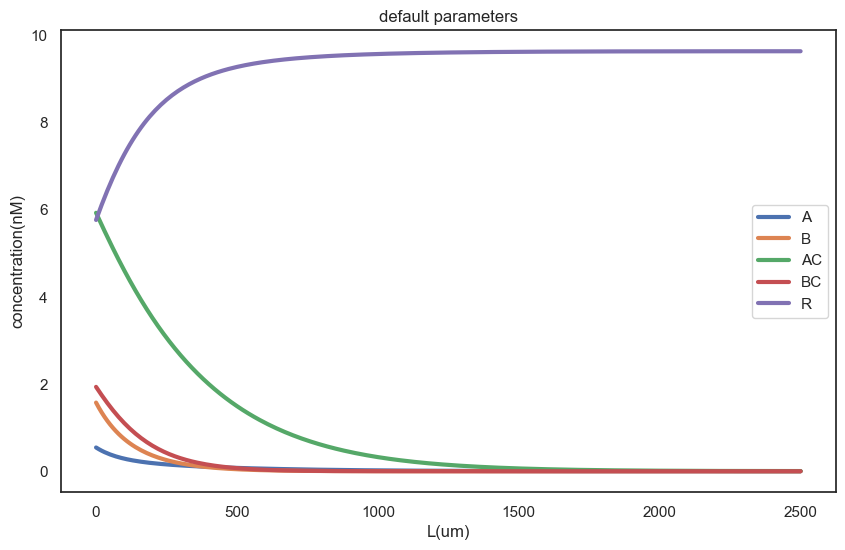

In [20]:
x = np.linspace(0.0, L, len(c_0_tuple[0]))
A = sol[0][-1]
B = sol[1][-1]
C = sol[2][-1]
R = sol[3][-1]
AC = sol[4][-1]
BC = sol[5][-1]
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x[:-sender_region], A[sender_region:], linewidth=3, label='A')
ax.plot(x[:-sender_region], B[sender_region:], linewidth=3, label='B')
ax.plot(x[:-sender_region], AC[sender_region:], linewidth=3, label='AC')
ax.plot(x[:-sender_region], BC[sender_region:], linewidth=3, label='BC')
ax.plot(x[:-sender_region], R[sender_region:], linewidth=3, label='R')
plt.xlabel("L(um)")
plt.ylabel("concentration(nM)")
plt.title('default parameters')
plt.legend()
plt.show()

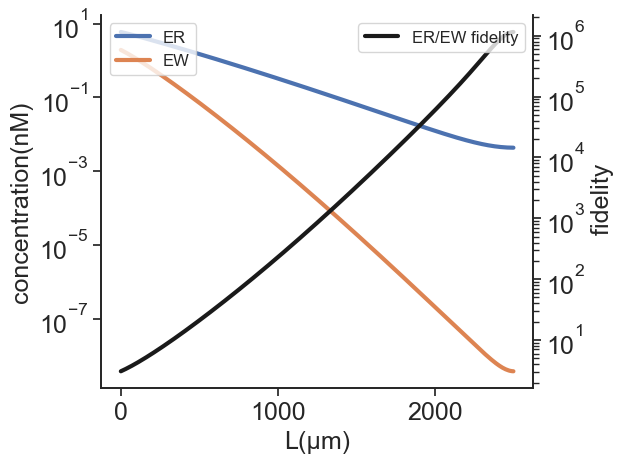

In [21]:
fig, ax1 = plt.subplots(dpi=100)    

x = np.linspace(0,L,n_gridpoints)
ax1.spines["top"].set_visible(False)
ax1.semilogy(x[:-sender_region], sol[4][-1][sender_region:],linewidth=3, label='ER')
ax1.semilogy(x[:-sender_region], sol[5][-1][sender_region:],linewidth=3, label='EW')
ax1.set_xlabel("L(μm)",fontsize=18)
ax1.set_ylabel("concentration(nM)",fontsize=18)
ax1.legend(loc='upper left', fontsize=12)
plt.tick_params(bottom = bool, labelsize=18)

ax2 = ax1.twinx()
fidelity = sol[4][-1]/sol[5][-1]
ax2.spines["top"].set_visible(False)
ax2.semilogy(x[:-sender_region], (fidelity[sender_region:]), linewidth=3, label='ER/EW fidelity',color='k')
#ax2.plot(x[:-sender_region], fidelity[sender_region:], linewidth=0.8, label='fidelity',color='k')
#ax2.fill_between(x[:-sender_region], increased_fidelity_largerD[sender_region:], increased_fidelity_lowD[sender_region:], alpha=.5, linewidth=0)
ax2.set_ylabel(" fidelity", fontsize=18)
ax2.legend(loc='upper right',fontsize=12)

plt.tick_params(labelsize=18)

fig.tight_layout()

publish_on = True
if publish_on:  
    ax.tick_params(axis="y", labelleft=True, size=14)
    ax.tick_params(axis="x", labelbottom=True, size=14)
    plt.savefig('figures fig1a.svg', dpi=150)
else:
    ax.set_ylabel(r'fidelity, $\log_{10}(AA_{p}/BA_{p})$', fontsize=14)
    ax.set_xlabel(r'koff', fontsize=14)

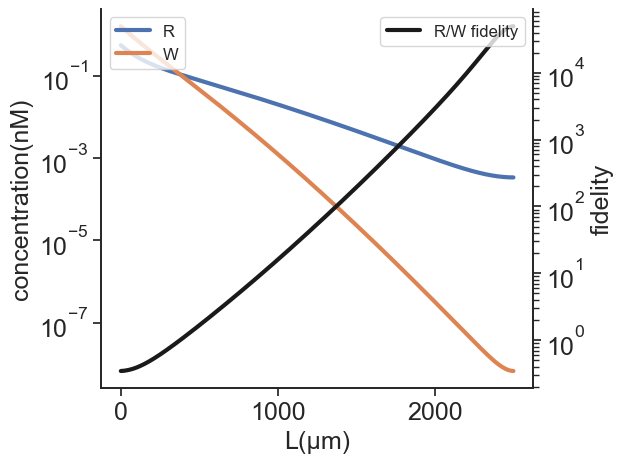

In [22]:
fig, ax1 = plt.subplots(dpi=100)    

x = np.linspace(0,L,n_gridpoints)
ax1.spines["top"].set_visible(False)
ax1.semilogy(x[:-sender_region], sol[0][-1][sender_region:],linewidth=3, label='R')
ax1.semilogy(x[:-sender_region], sol[1][-1][sender_region:],linewidth=3, label='W')
ax1.set_xlabel("L(μm)",fontsize=18)
ax1.set_ylabel("concentration(nM)",fontsize=18)
ax1.legend(loc='upper left', fontsize=12)
plt.tick_params(bottom = bool, labelsize=18)

ax2 = ax1.twinx()
fidelity = sol[0][-1]/sol[1][-1]
ax2.spines["top"].set_visible(False)
ax2.semilogy(x[:-sender_region], fidelity[sender_region:], linewidth=3, label='R/W fidelity',color='k')
#ax2.plot(x[:-sender_region], fidelity[sender_region:], linewidth=0.8, label='fidelity',color='k')
#ax2.fill_between(x[:-sender_region], increased_fidelity_largerD[sender_region:], increased_fidelity_lowD[sender_region:], alpha=.5, linewidth=0)
ax2.set_ylabel("fidelity", fontsize=18)
ax2.legend(loc='upper right',fontsize=12)

plt.tick_params(labelsize=18)

fig.tight_layout()

publish_on = True
if publish_on:  
    ax.tick_params(axis="y", labelleft=True, size=14)
    ax.tick_params(axis="x", labelbottom=True, size=14)
    plt.savefig('figures fig1a_freeab.svg', dpi=150)
else:
    ax.set_ylabel(r'fidelity, $\log_{10}(AA_{p}/BA_{p})$', fontsize=14)
    ax.set_xlabel(r'koff', fontsize=14)

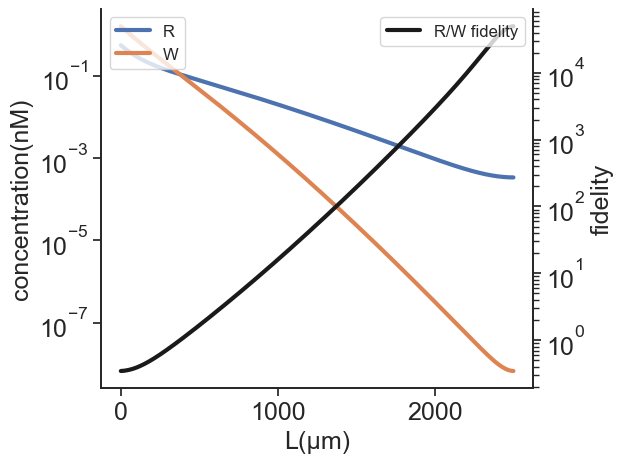

In [26]:
fig, ax1 = plt.subplots(dpi=100)    

x = np.linspace(0,L,n_gridpoints)
ax1.spines["top"].set_visible(False)
ax1.plot(x[:-sender_region], sol[0][-1][sender_region:],linewidth=3, label='R')
ax1.plot(x[:-sender_region], sol[1][-1][sender_region:],linewidth=3, label='W')
ax1.set_xlabel("L(μm)",fontsize=18)
ax1.set_ylabel("concentration(nM)",fontsize=18)
ax1.legend(loc='upper left', fontsize=12)
ax1.set_yscale('log')
plt.tick_params(bottom = bool, labelsize=18)

ax2 = ax1.twinx()
fidelity = sol[0][-1]/sol[1][-1]
ax2.spines["top"].set_visible(False)
ax2.plot(x[:-sender_region], fidelity[sender_region:], linewidth=3, label='R/W fidelity',color='k')
#ax2.plot(x[:-sender_region], fidelity[sender_region:], linewidth=0.8, label='fidelity',color='k')
#ax2.fill_between(x[:-sender_region], increased_fidelity_largerD[sender_region:], increased_fidelity_lowD[sender_region:], alpha=.5, linewidth=0)
ax2.set_ylabel("fidelity", fontsize=18)
ax2.legend(loc='upper right',fontsize=12)
ax2.set_yscale('log')



plt.tick_params(labelsize=18)

fig.tight_layout()

publish_on = True
if publish_on:  
    ax.tick_params(axis="y", labelleft=True, size=14)
    ax.tick_params(axis="x", labelbottom=True, size=14)
    plt.savefig('figures fig1a_freeab.svg', dpi=150)
else:
    ax.set_ylabel(r'fidelity, $\log_{10}(AA_{p}/BA_{p})$', fontsize=14)
    ax.set_xlabel(r'koff', fontsize=14)